In [1]:
from qiskit import *
import qiskit.tools.jupyter
import numpy as np
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
from qiskit.aqua.components.variational_forms import VariationalForm
from qiskit.aqua.components.initial_states import Zero, VarFormBased
from qiskit.aqua.operators import MatrixOperator, TPBGroupedWeightedPauliOperator
from qiskit.aqua.operators.op_converter import to_tpb_grouped_weighted_pauli_operator
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.algorithms.adaptive import VQE

In [3]:
from qiskit.visualization import plot_histogram

In [4]:
from scipy.sparse import *
from scipy import *

# Parameters

In [5]:
# even space
# [0.13028114, -1.18048464, 0.17737505]
# [ 0.12398951, -1.18068356,  0.15356187]
t0_1 = 0.13028114 # theta-angle values
t1_1 = -1.18048464
t2_1 = 0.17737505
# odd space
# [-0.30306561, -1.02142291,  0.15013751
# [ 2.8238186 , -5.22031494,  0.16478762]
t0_2 = 2.8238186
t1_2 = -5.22031494
t2_2 = 0.16478762
def angle(theta=0., phi=0., lam=0.):
    return [theta, phi, lam]
t1 = [angle(t_i) for t_i in [t0_1, t1_1, t2_1]]
t2 = [angle(t_i) for t_i in [t0_2, t1_2, t2_2]]
# define number of qubits and bits
nqubits = 2 
# create registers
q0 = QuantumRegister(nqubits, name="q0")
q1 = QuantumRegister(nqubits, name="q1")
a = QuantumRegister(1, name="a")
c0 = ClassicalRegister(nqubits, name="c0")
c1 = ClassicalRegister(nqubits, name="c1")

# Even subspace

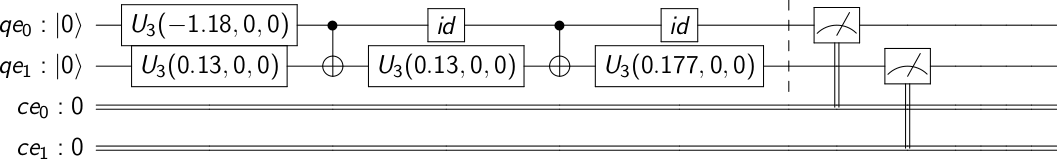

In [6]:
# create registers
q_even = QuantumRegister(nqubits, name="qe")
c_even = ClassicalRegister(nqubits, name="ce")
regs0 = [q_even, c_even]
# create circuit
circ0 = QuantumCircuit(*regs0, name="even")
circ0.u3(*(t1[1]), 0)  # u3(*angles, q)
circ0.u3(*(t1[0]), 1)
############
circ0.cx(0, 1)    # cx(ctrl, tgt)
############
circ0.u3(*(t1[0]), 1)
circ0.iden(0)
############
circ0.cx(0, 1)
############
circ0.u3(*(t1[2]), 1)
circ0.iden(0)
# measurement circuit
meas0 = QuantumCircuit(*regs0, name="meas0")
# barrier prevents optimizations
# from reordering gates across its source line
meas0.barrier(range(2)) 
############ MEASURE ANCILLARY QUBIT
meas0.measure(q_even, c_even)#  map qubits to clbits
# Full circuit
qc0 = circ0 + meas0
qc0.draw(output='latex', scale=0.5)

# Odd subspace

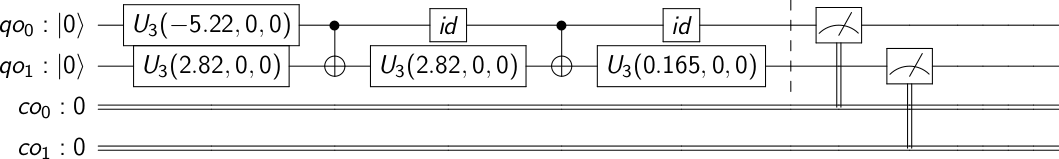

In [7]:
# create registers
q_odd = QuantumRegister(nqubits, name="qo")
c_odd = ClassicalRegister(nqubits, name="co")
regs1 = [q_odd, c_odd]
# create circuit
circ1 = QuantumCircuit(*regs1, name="odd")
############
circ1.u3(*(t2[1]), 0)  # u3(*angles, q)
circ1.u3(*(t2[0]), 1)
############
circ1.cx(0, 1)    # cx(ctrl, tgt)
############
circ1.u3(*(t2[0]), 1)
circ1.iden(0)
############
circ1.cx(0, 1)
############
circ1.u3(*(t2[2]), 1)
circ1.iden(0)
# measurement circuit
meas1 = QuantumCircuit(*regs1, name="meas1")
# barrier prevents optimizations
# from reordering gates across its source line
meas1.barrier(range(2)) 
############ MEASURE ANCILLARY QUBIT
meas1.measure(q_odd, c_odd)#  map qubits to clbits
# Full circuit
qc1 = circ1 + meas1
qc1.draw(output='latex', scale=0.5)

# Superposition

## +

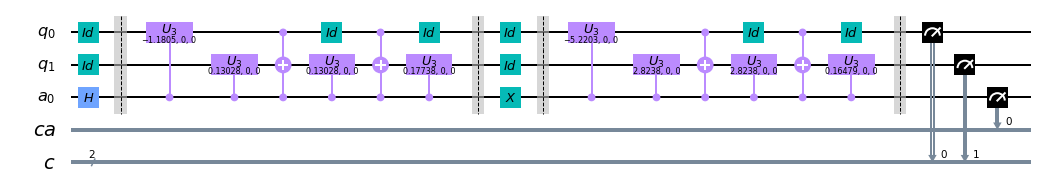

In [8]:
# create registers
q = QuantumRegister(nqubits, name="q")
a = QuantumRegister(1, name="a")
c = ClassicalRegister(nqubits, name="c")
ca = ClassicalRegister(1, name="ca")
regs = [q, a, ca, c]
circ = QuantumCircuit(*regs, name="superposition +")
# Construct circuit
circ.iden(q[0])
circ.iden(q[1])
circ.h(a[0])
############
circ.barrier(range(3)) 
# even parity
circ.cu3(*(t1[1]), a[0], q[0])  # u3(*angles, q)
circ.cu3(*(t1[0]), a[0], q[1])
############
circ.ccx(a[0], q[0], q[1])    # cx(ctrl, tgt)
############
circ.cu3(*(t1[0]), a[0], q[1])
circ.iden(q[0])
############
circ.ccx(a[0], q[0], q[1])
############
circ.cu3(*(t1[2]), a[0], q[1])
circ.iden(q[0])
############
circ.barrier(range(3)) 
# switch ancilla
circ.iden(q[0])
circ.iden(q[1])
circ.x(a[0])
############
circ.barrier(range(3)) 
# odd parity
circ.cu3(*(t2[1]), a[0], q[0])  # u3(*angles, q)
circ.cu3(*(t2[0]), a[0], q[1])
############
circ.ccx(a[0], q[0], q[1])    # cx(ctrl, tgt)
############
circ.cu3(*(t2[0]), a[0], q[1])
circ.iden(q[0])
############
circ.ccx(a[0], q[0], q[1])
############
circ.cu3(*(t2[2]), a[0], q[1])
circ.iden(q[0])
# measurement circuit
meas = QuantumCircuit(*regs, name="meas_circuit")
# barrier prevents optimizations
# from reordering gates across its source line
# meas.barrier(range(3)) 
############ apply another hadamard, 
# meas.iden(q[0])
# meas.iden(q[1])
# meas.h(a[0])
############ MEASURE ANCILLARY QUBIT
# meas.iden(q[0])
# meas.iden(q[1])
# meas.measure(a[0], ca[0])
############
meas.barrier(range(3)) 
############
meas.measure(q, c)#  map qubits to clbits
meas.measure(a[0], ca[0])
# meas.measure(q1, c1)#  map qubits to clbits
# Full circuit
qc = circ + meas
qc.draw(output='mpl', scale=0.5, filename='my_circuit.png', plot_barriers=True, fold=40)

## -

# Measurements

In [9]:
nshots = 1021 * 16
backend_sim = Aer.get_backend('qasm_simulator')

In [10]:
# Expected coefficients
# outcome ordering: 00, 01, 10, 11
cf0 = [0.810968, 0.18047, -0.554375, -0.0492955]
cf1 = [0.84982, -0.197185, 0.487421, 0.036659]

In [11]:
pb0 = np.array(cf0)**2
pb1 = np.array(cf1)**2
print(pb0)
print(pb1)

[0.6576691  0.03256942 0.30733164 0.00243005]
[0.72219403 0.03888192 0.23757923 0.00134388]


## Even

In [12]:
# execute the circuit on qasm_simulator backend;
# set repeats (measurement shots) at 1024 (default)
# memory = True:
#   per-shot measurement bitstrings are returned 
#   as well (provided the backend supports it)
job_sim0 = execute(qc0, backend_sim, shots=nshots, memory=True)
result_sim0 = job_sim0.result()

In [13]:
# can get counts from result object using get_counts() method:
counts0 = result_sim0.get_counts(qc0)
print(counts0)

{'11': 37, '01': 5079, '10': 541, '00': 10679}


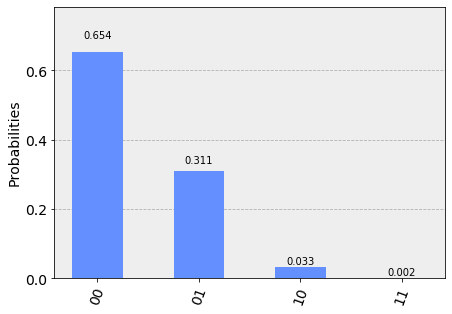

In [14]:
counts0 = result_sim0.get_counts(qc0)
plot_histogram(counts0)

## Odd

In [15]:
# execute the circuit on qasm_simulator backend;
# set repeats (measurement shots) at 1024 (default)
# memory = True:
#   per-shot measurement bitstrings are returned 
#   as well (provided the backend supports it)
job_sim1 = execute(qc1, backend_sim, shots=nshots, memory=True)
result_sim1 = job_sim1.result()

In [16]:
# can get counts from result object using get_counts() method:
counts1 = result_sim1.get_counts(qc1)
print(counts1)

{'11': 39, '01': 4164, '10': 670, '00': 11463}


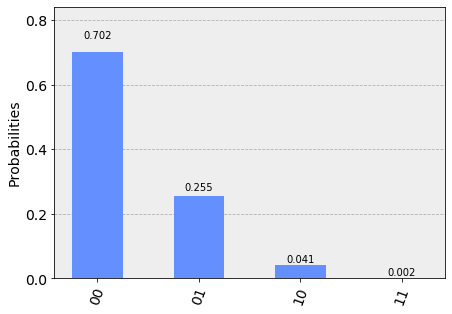

In [17]:
counts1 = result_sim1.get_counts(qc1)
plot_histogram(counts1)

In [18]:
{'00': (0.6688324064016342, 0.0051803584953980415),
 '01': (0.2897534817457199, 0.004959148504295891),
 '10': (0.03958307206630707, 0.002145388528592462),
 '11': (0.0018310397863388062, 0.00046907548273070784)}

{'00': (0.6688324064016342, 0.0051803584953980415),
 '01': (0.2897534817457199, 0.004959148504295891),
 '10': (0.03958307206630707, 0.002145388528592462),
 '11': (0.0018310397863388062, 0.00046907548273070784)}

## Superposition

### +

In [19]:
# execute the circuit on qasm_simulator backend;
# set repeats (measurement shots) at 1024 (default)
# memory = True:
#   per-shot measurement bitstrings are returned 
#   as well (provided the backend supports it)
job_sim = execute(qc, backend_sim, shots=nshots, memory=True)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)
print(counts)

{'01 1': 2016, '01 0': 2556, '10 1': 311, '11 1': 18, '00 0': 5383, '10 0': 254, '11 0': 8, '00 1': 5790}


In [20]:
pb0/2

array([0.32883455, 0.01628471, 0.15366582, 0.00121502])

In [21]:
pb1/2

array([0.36109702, 0.01944096, 0.11878962, 0.00067194])

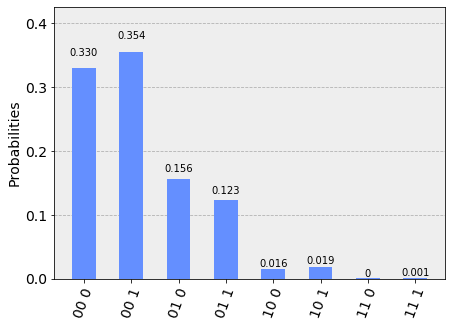

In [22]:
counts = result_sim.get_counts(qc)
plot_histogram(counts)